EX 1

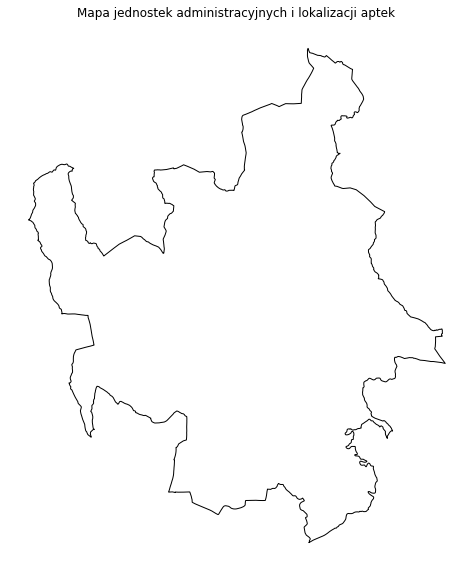

In [71]:
import os
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt


os.chdir(r'D:\Study_Coimbra\Maps_GISWEB\class1\f1ex1')
file_paths = [file for file in os.listdir() if file.endswith('.shp') and file.startswith('c')]
coimbra = 'limites_coimbra.shp'

target_crs = CRS.from_epsg(3763)
coimbra_df = gpd.read_file(coimbra)
coimbra_df.crs = target_crs
# coimbra_df = coimbra_df.to_crs(target_crs)


gdfs = []
for file_path in file_paths:
    gdf = gpd.read_file(file_path)
    gdf.crs = target_crs

fig, ax = plt.subplots(figsize=(10, 10))
coimbra_df.plot(ax=ax, color='white', edgecolor='black')
for gdf in gdfs:
    gdf.plot(ax=ax, color='red', markersize=5)

# Wyświetl mapę
plt.title('Mapa jednostek administracyjnych i lokalizacji aptek')
plt.axis('off')
plt.show()

# clipped_gdfs = []
# for gdf in gdfs:
#     clipped_gdf = gpd.overlay(gdf, coimbra_df, how='intersection')
#     clipped_gdfs.append(clipped_gdf)

# merged_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(unary_union([gdf.unary_union for gdf in clipped_gdfs])), crs=target_crs)

# # Zapisz do pliku 'result_ex1.shp'
# merged_gdf.to_file('result_ex1.shp')

Ex 2

<AxesSubplot: >

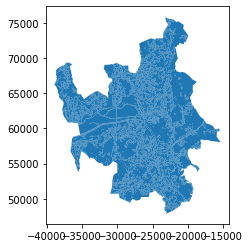

In [46]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

os.chdir(r'D:\Study_Coimbra\Maps_GISWEB\class1')

area2007 = r'f1ex2\cmb_cos07.shp'
area2018 = r'f1ex2\cmb_cos18.shp'

df2007 = gpd.read_file(area2007)
df2018 = gpd.read_file(area2018)

df2007.plot()

In [10]:
# print(df2007.head()) # display head of attribute table
# print(df2007.columns) 
print(df2007.COS07n1_L.head())
pd.unique(df2007.COS07n1_L)

0    Territórios artificializados
1    Territórios artificializados
2    Territórios artificializados
3    Territórios artificializados
4    Territórios artificializados
Name: COS07n1_L, dtype: object


array(['Territórios artificializados', 'Agricultura', 'Pastagens',
       'Florestas', 'Matos', 'Espaços descobertos ou com pouca vegetação',
       'Zonas húmidas', 'Massas de água superficiais'], dtype=object)

<AxesSubplot: >

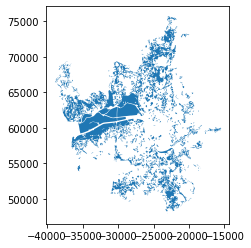

In [45]:
# filter
df2007_agr = df2007[df2007.COS07n1_L == 'Agricultura']
df2007_agr.plot()

<AxesSubplot: >

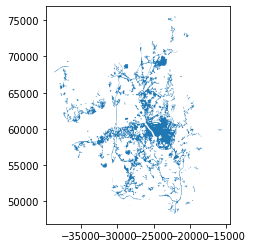

In [47]:
df2018_terr_art = df2018[df2018.COS18n1_L == 'Territórios artificializados']
df2018_terr_art.plot()

91.33955595217054

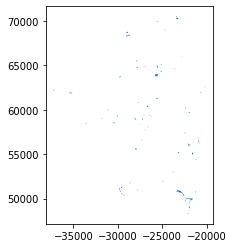

In [48]:
common_polygons = gpd.overlay(df2007_agr, df2018_terr_art, how='intersection', keep_geom_type=True)
total_area_hectares = sum(common_polygons['geometry'].area / 10_000)

common_polygons.plot()

total_area_hectares

EX 3

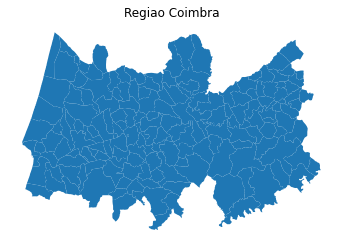

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DICOFRE     168 non-null    object  
 1   Freguesia   168 non-null    object  
 2   Concelho    168 non-null    object  
 3   Distrito    168 non-null    object  
 4   Area_ha     168 non-null    float64 
 5   Des_Simpli  168 non-null    object  
 6   geometry    168 non-null    geometry
dtypes: float64(1), geometry(1), object(5)
memory usage: 9.3+ KB


In [40]:
fregRegio = gpd.read_file(r'f1ex3\freg_regiao_coimbra.shp')

fregRegio.plot()
plt.title('Regiao Coimbra')
plt.axis('off')  # Wyłączenie osi
plt.show()

fregRegio.info()

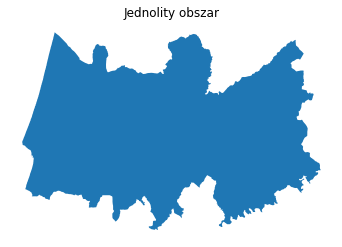

In [43]:
jednolity_obszar = fregRegio.unary_union

# Konwertuj jednolity obszar na GeoDataFrame
jednolity_obszar_gdf = gpd.GeoDataFrame(geometry=[jednolity_obszar])

# Wyświetl mapę jednolitego obszaru
jednolity_obszar_gdf.plot()
plt.title('Jednolity obszar')
plt.axis('off')  # Wyłączenie osi
plt.show()

Ex 4

<AxesSubplot: >

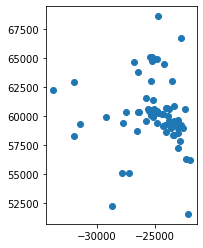

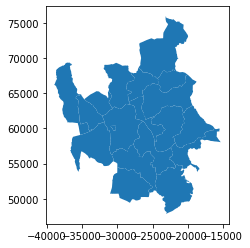

In [51]:
location_farmacias = gpd.read_file('f1ex4/farmacias_e_para.shp')
freg_coimbra = gpd.read_file('f1ex4/freg_cmb.shp')
location_farmacias.plot()
freg_coimbra.plot()

In [64]:
joined_data = gpd.sjoin(location_farmacias, freg_coimbra, how='left', op='within')

# Wyświetl wynik
apteki_w_freguesiach = joined_data.groupby('Freguesia').size().reset_index(name='farmacies')
freg_coimbra_with_apteki = freg_coimbra.set_index('Freguesia').join(apteki_w_freguesiach.set_index('Freguesia'))

# Wyświetl wynik
freg_coimbra_with_apteki

c:\Users\Marta\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Des_Simpli,idconc,idfreg,popres11,geometry,farmacies
Freguesia,,,,,,
Almalaguês,Almalaguês,0603,060301,3111,"POLYGON ((-20725.391 54329.725, -20725.501 543...",1.0
Brasfemes,Brasfemes,0603,060309,1969,"POLYGON ((-20373.719 67919.039, -20371.189 679...",1.0
Ceira,Ceira,0603,060311,3701,"POLYGON ((-15310.581 58040.966, -15517.961 580...",1.0
Cernache,Cernache,0603,060312,4048,"POLYGON ((-25425.752 50852.985, -25426.372 508...",1.0
Santo António dos Olivais,Santo António dos Olivais,0603,060318,38936,"POLYGON ((-20630.040 62210.340, -20630.831 622...",19.0
São João do Campo,São João do Campo,0603,060320,2073,"POLYGON ((-30747.845 62907.662, -30742.494 628...",1.0
São Silvestre,São Silvestre,0603,060324,3122,"POLYGON ((-34722.973 64155.281, -34706.203 641...",1.0
Torres do Mondego,Torres do Mondego,0603,060329,2402,"POLYGON ((-17637.484 61128.630, -17604.283 610...",NaN
União das freguesias de Antuzede e Vil de Matos,Antuzede e Vil de Matos,0603,060332,3146,"POLYGON ((-28119.941 67978.243, -28113.110 679...",NaN


In [63]:
freg_coimbra_with_apteki['result'] = (freg_coimbra_with_apteki['farmacies'] / freg_coimbra_with_apteki['popres11']) * 10000

freg_coimbra_with_apteki['result']

Freguesia
Almalaguês                                                                           3.214401
Brasfemes                                                                            5.078720
Ceira                                                                                2.701972
Cernache                                                                             2.470356
Santo António dos Olivais                                                            4.879803
São João do Campo                                                                    4.823927
São Silvestre                                                                        3.203075
Torres do Mondego                                                                         NaN
União das freguesias de Antuzede e Vil de Matos                                           NaN
União das freguesias de Assafarge e Antanhol                                         3.772161
União das freguesias de Coimbra (Sé Nova, Santa Cr

Ex 5